# Week 13 Assignment: Topic Modeling

**DATA110**  
*Brian Roepke*  

Using the same women's clothing dataset from Midterm #2, perform Topic Modeling using LDA using either packages: Gensim  or sklearn on the reviews text.  


Given that there are 6 departments, you can use  6 topics.  Bonus if you apply coherence computations against multiple models for model selection, in order to determine the optimal number of topics.



References:

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [3]:
df.dropna(subset=['Department Name', 'Class Name', 'Review Text'], inplace=True)

In [4]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

In [5]:
# count of nulls
df.isnull().sum()

Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Department Name            0
Class Name                 0
dtype: int64

In [6]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [7]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

In [8]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [9]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


In [10]:
wordlen = df['Text'].str.split().map(lambda x: len(x))
wordlen.describe()

count    22626.000000
mean        63.121321
std         29.086751
min          2.000000
25%         39.000000
50%         62.000000
75%         92.000000
max        121.000000
Name: Text, dtype: float64

In [11]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [12]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [13]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [14]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Topic Modeling

In [15]:
clean_docs = df['Text_Processed'].to_list()

# first 5 docs
clean_docs[:5]

['absolutely wonderful silky sexy comfortable ',
 'love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite 58 love length hit little knee would definitely true midi someone truly petite ',
 'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c ',
 'favorite buy love love love jumpsuit fun flirty fabulous every time wear get nothing great compliment ',
 'flattering shirt shirt flattering due adjustable front tie perfect length wear legging sleeveless pair well cardigan love shirt ']

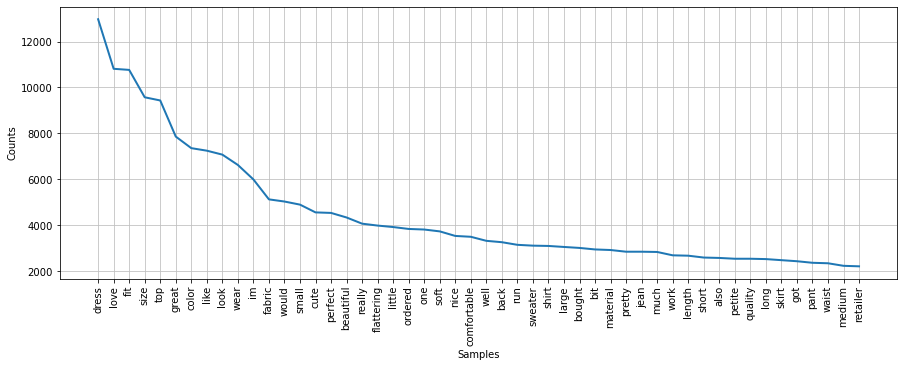

In [16]:
texts = "".join(clean_docs)
word_tokens = word_tokenize(texts)
#fdist.most_common(50)

plt.figure(figsize=(15, 5)) 
fdist = FreqDist(word_tokens)
fdist.plot(50);

# Determine the Optimal Number of Clusters

## Elbow Method

To select the best number of clusters, we'll use the Elbow method.  Per [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

> *In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, such as the number of principal components to describe a data set.*

[Tutorial: How to determine the optimal number of clusters for k-means clustering](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [17]:
#vectorization of features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_docs)

X.shape

(22626, 18546)

In [18]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

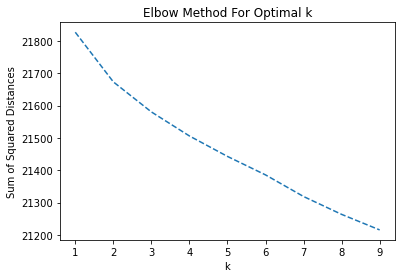

In [19]:
ax = sns.lineplot(x=K, y=Sum_of_squared_distances)
ax.lines[0].set_linestyle("--")
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Conclusion:** Based on this method, the appropriate number of clusters is not totally clear. 

In [20]:
def get_silhouette_score(X, k):
    for n_clusters in range(2, k):
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        y = clusterer.fit_predict(X)

        message = "For n_clusters = {} The average silhouette_score is: {}"
        print(message.format(n_clusters, silhouette_score(X, y)))
        
get_silhouette_score(X, 10)     

For n_clusters = 2 The average silhouette_score is: 0.005158957947959958
For n_clusters = 3 The average silhouette_score is: 0.0054280750132190215
For n_clusters = 4 The average silhouette_score is: 0.006537274584641789
For n_clusters = 5 The average silhouette_score is: 0.007561045537325558
For n_clusters = 6 The average silhouette_score is: 0.007061001255105283
For n_clusters = 7 The average silhouette_score is: 0.008841133863256995
For n_clusters = 8 The average silhouette_score is: 0.008062911309296796
For n_clusters = 9 The average silhouette_score is: 0.008760478475238226


**Conclusion:** 

## Dendrogram

> *A dendrogram is a diagram representing a tree. In hierarchical clustering, it illustrates the arrangement of the clusters produced by the corresponding analyses*

https://en.wikipedia.org/wiki/Dendrogram

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples: 
                current_count += 1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float) 
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None) 
model = model.fit(X.toarray())
plt.figure(figsize=(10, 10)) 
plt.title('Hierarchical Clustering Dendrogram')
# plot the top levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3, show_leaf_counts=True)
plt.show();

# Clustering Model

In [26]:
true_k = 6
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=42)
kmeans.fit(X)


print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:  
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 like
 fit
 look
 color
 fabric
 skirt
 love
 size
 im
 would
Cluster 1:
 dress
 love
 fit
 beautiful
 great
 size
 perfect
 wear
 flattering
 comfortable
Cluster 2:
 small
 size
 run
 large
 medium
 big
 ordered
 fit
 im
 wear
Cluster 3:
 top
 love
 great
 cute
 fit
 color
 look
 size
 wear
 like
Cluster 4:
 shirt
 love
 great
 cute
 fit
 look
 color
 soft
 wear
 like
Cluster 5:
 love
 great
 sweater
 jean
 pant
 fit
 perfect
 soft
 color
 comfortable


In [22]:
# assign the data labels back to the dataframe
df['clusters'] = kmeans.labels_

df.sample(10, random_state=42)

,Age,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name,Text,text_len,Text_Processed,clusters
6673,53,5,1,1,Jackets,Jackets,Just purchased tonight and love i this little...,204,purchased tonight love little jacket embroider...,0
8079,48,5,1,3,Bottoms,Skirts,Seriously beautiful This skirt is stunning. li...,519,seriously beautiful skirt stunning like review...,0
2156,62,5,1,1,Tops,Knits,Need them all! Ordered this on a whim while ta...,418,need ordered whim taking advantage promotion n...,5
5337,37,5,1,2,Dresses,Dresses,"Pretty! I am five foot tall, about 103lb and g...",152,pretty five foot tall 103lb got petite zero fi...,0
13662,42,5,1,1,Bottoms,Skirts,Love love this skirt! quality is great and so...,146,love love skirt quality great comfortable even...,5
6889,36,5,1,0,Intimate,Lounge,Love this cardigan! i've been searching for a...,252,love cardigan ive searching comfortable lounge...,5
20210,51,4,1,0,Tops,Knits,Love it I bought the deep maroon which is beau...,386,love bought deep maroon beautiful absolutely l...,1
22005,55,3,1,0,Tops,Knits,Nice material but weird fit I ordered it in tw...,148,nice material weird fit ordered two color exce...,0
7363,69,5,1,5,Tops,Knits,So cute and great fit I am so pleased with thi...,291,cute great fit pleased top slightly fitted 53 ...,3
21791,44,3,0,0,Tops,Knits,It's ok The fabric is great quality but it str...,148,ok fabric great quality stretch much around wa...,0


In [25]:
new_docs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
            'This skirt has really horible quality and I hate it!',
            'A super cute top with the perfect fit.',
            'The most gorgeous pair of jeans I have seen.',
            'this item is too little and tight.']

pred = kmeans.predict(vectorizer.transform(new_docs))
print(pred)

[1 0 3 0 0]


# GenSim

In [28]:
clean_docs[:1]

['absolutely wonderful silky sexy comfortable ']

In [33]:
tokenized_docs = [word_tokenize(word) for word in clean_docs]

In [34]:
# create a dictionary from the corpus
dictionary = gensim.corpora.Dictionary(tokenized_docs)
print(dictionary)

# Term Document Frequency 
# convert our entire corpus to a list of vectors:
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# View the first doc
print(bow_corpus[0])

Dictionary(18578 unique tokens: ['absolutely', 'comfortable', 'sexy', 'silky', 'wonderful']...)
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [37]:
doc = bow_corpus[1]
for i in range(len(doc)):
    print (f"Word {doc[i][0]} ({dictionary[doc[i][0]]}) appears {doc[i][1]} times")

Word 5 (58) appears 1 times
Word 6 (bc) appears 2 times
Word 7 (bought) appears 1 times
Word 8 (definitely) appears 1 times
Word 9 (dress) appears 1 times
Word 10 (find) appears 1 times
Word 11 (glad) appears 1 times
Word 12 (happened) appears 1 times
Word 13 (hit) appears 1 times
Word 14 (im) appears 1 times
Word 15 (knee) appears 1 times
Word 16 (length) appears 1 times
Word 17 (little) appears 1 times
Word 18 (love) appears 2 times
Word 19 (midi) appears 1 times
Word 20 (never) appears 1 times
Word 21 (online) appears 1 times
Word 22 (ordered) appears 1 times
Word 23 (petite) appears 3 times
Word 24 (pretty) appears 1 times
Word 25 (someone) appears 1 times
Word 26 (sooo) appears 1 times
Word 27 (store) appears 1 times
Word 28 (true) appears 1 times
Word 29 (truly) appears 1 times
Word 30 (would) appears 2 times


# Topic Modeling

In [38]:
NUM_TOPICS = 6

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=NUM_TOPICS, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
### View the topics in LDA model
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.030*"coat" + 0.026*"wait" + 0.024*"seems" + 0.021*"tshirt" + 0.019*"lining" + 0.018*"weather" + 0.017*"month" + 0.012*"chic" + 0.012*"let" + 0.012*"silhouette"')
(1, '0.035*"top" + 0.030*"like" + 0.027*"look" + 0.022*"fabric" + 0.018*"would" + 0.018*"beautiful" + 0.014*"really" + 0.013*"much" + 0.012*"bit" + 0.012*"back"')
(2, '0.046*"love" + 0.032*"great" + 0.031*"color" + 0.028*"wear" + 0.018*"perfect" + 0.018*"flattering" + 0.016*"fit" + 0.016*"cute" + 0.015*"soft" + 0.015*"nice"')
(3, '0.058*"high" + 0.053*"regular" + 0.025*"wash" + 0.023*"elastic" + 0.018*"cheap" + 0.017*"buying" + 0.014*"yes" + 0.013*"slit" + 0.013*"shown" + 0.013*"34"')
(4, '0.023*"strap" + 0.021*"youre" + 0.019*"55" + 0.018*"ever" + 0.018*"flat" + 0.017*"night" + 0.017*"local" + 0.017*"wedding" + 0.017*"classic" + 0.016*"bad"')
(5, '0.086*"dress" + 0.060*"size" + 0.039*"fit" + 0.037*"im" + 0.032*"small" + 0.022*"ordered" + 0.020*"run" + 0.019*"large" + 0.017*"petite" + 0.016*"waist"')


In [41]:
new_doc = 'This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.'
new_doc = process_string(new_doc)
new_doc = word_tokenize(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)

print(new_doc_bow)
print(lda_model.get_document_topics(new_doc_bow))

[(9, 1), (18, 1), (30, 1), (132, 1), (3456, 1), (6772, 1)]
[(0, 0.022831386), (1, 0.35062858), (2, 0.35865673), (3, 0.024053758), (4, 0.024860613), (5, 0.2189689)]


# Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [42]:
def lda_scoring (model, corpus, text, dictionary):

    # Compute Perplexity
    print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, 
                                         texts=text, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

In [44]:
lda_scoring(lda_model, bow_corpus, tokenized_docs, dictionary)


Perplexity:  -7.123051830133696

Coherence Score:  0.309430343359335


In [46]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_viz)